# CVRP HW2 - part 2
In this part, you will implement **unconditional** and **conditional** PixelCNN on MNIST dataset.
To have faster training efficency, GPU acceleration is recommended. However, don't worry if you reach your GPU usage limit on Colab. This part can still be completed within a reasonable timeframe using a standard CPU.

PixelCNNs are a type of autoregressive generative model that generate images by modeling the joint distribution of pixels as a product of conditional distributions. In PixelCNN, the pixels are generated one by one in a specific order, with each pixel conditioned on the previously generated pixels. The model uses masked convolutions to ensure that the prediction of each pixel only depends on the already generated pixels, following the raster scan order. For more details, please refer to Lecture 13.

Some notes:
- This part takes 50 points in total
- There is **no questions** in this part
- If you made any modifications on the cells with "DO NOT MODIFY" label, please be sure to write a detailed README, otherwise, TA will have a hard time grading your code...
- If you find it's hard to put all the things into a single notebook, you can have additional files. Make sure you have a README as well.
- Please zip all the notebooks or files you have to a compressed zip file before submission.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


### MNIST dataset loader
Please do not modify this cell

In [ ]:
# NOTE: DO NOT MODIFY

def binarize_image(tensor):
    return (tensor > 0.5).float()

tensor_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(binarize_image)
])

batch_size = 128
train_dataset = datasets.MNIST(root = "./data",
							train = True,
							download = True,
							transform = tensor_transform)
test_dataset = datasets.MNIST(root = "./data",
							train = False,
							download = True,
							transform = tensor_transform)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
										batch_size = batch_size,
										shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
										batch_size = batch_size,
										shuffle = False)


100%|██████████| 9.91M/9.91M [00:01<00:00, 4.98MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 64.9kB/s]
100%|██████████| 1.65M/1.65M [00:06<00:00, 244kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.73MB/s]


## **PixelCNN**

Tasks:
- [15 pts] Implement Masked Convolution by finishing the `MaskedConv2d()` function
- [15 pts] Implement PixelCNN with your `MaskedConv2d()`
- The training function for unconditional PixelCNN is provided, there is no need to modify `train()`

In [ ]:
bce = F.binary_cross_entropy

def train(dataloader, model, optimizer, epochs):
    losses = []

    for epoch in tqdm(range(epochs), desc='Epochs'):
        running_loss = 0.0

        for iter, (images, labels) in enumerate(dataloader):
            images = images.to(device)
            tgt = images.clone()
            pred = model(images)
            loss = bce(pred, tgt)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            avg_loss = running_loss * batch_size / len(train_dataset)
            losses.append(loss.item())

        tqdm.write(f'Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}')

    return losses


### Masked Convolution
The `MaskedConv2d()` function applies a mask to the convolutional filters in a 2D convolutional layer. The mask ensures that each pixel is only influenced by the pixels that have been generated before it. The function should allow for both type A and type B masks, where type A masks do not allow the central pixel to influence itself, and type B masks do.

In [ ]:
class MaskedConv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, mask_type, stride=1, padding=0, dilation=1, groups=1, bias=True):
        super().__init__(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias)

        assert mask_type in ('A', 'B'), "mask_type must be 'A' or 'B'"

        # Create the mask
        self.register_buffer("mask", torch.ones_like(self.weight))

        # Compute the center of the kernel
        k_h, k_w = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        center_h, center_w = k_h // 2, k_w // 2

        # Apply the mask
        self.mask[:, :, center_h, center_w + (mask_type == 'B'):] = 0  # Mask out pixels to the right
        self.mask[:, :, center_h + 1:] = 0  # Mask out pixels below

    def forward(self, x):
        self.weight.data *= self.mask  # Apply the mask before convolution
        return super().forward(x)


### Implement PixelCNN
Using your `MaskedConv2d()` function, implement the PixelCNN architecture. Your implementation should include several masked convolutional layers, nonlinear activations, and any necessary normalization layers. Ensure that your model is capable of generating images pixel by pixel.

In [ ]:

import torch.nn.functional as F

class MaskedConv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, mask_type, stride=1, padding=0, bias=True):
        super().__init__(in_channels, out_channels, kernel_size, stride, padding, bias=bias)

        assert mask_type in ('A', 'B'), "mask_type must be 'A' or 'B'"

        self.register_buffer("mask", torch.ones_like(self.weight))

        k_h, k_w = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        center_h, center_w = k_h // 2, k_w // 2

        self.mask[:, :, center_h, center_w + (mask_type == 'B'):] = 0
        self.mask[:, :, center_h + 1:] = 0

    def forward(self, x):
        self.weight.data *= self.mask
        return super().forward(x)

class PixelCNN(nn.Module):
    def __init__(self, input_channels=1, hidden_dim=64, num_layers=7, kernel_size=7):
        super().__init__()

        padding = kernel_size // 2  # To maintain the spatial dimensions
        self.layers = nn.ModuleList()

        # First layer: Mask-A convolution (ensures no dependence on the current pixel)
        self.layers.append(MaskedConv2d(input_channels, hidden_dim, kernel_size, mask_type='A', padding=padding))

        # Hidden layers: Mask-B convolutions (can depend on the current pixel but not future pixels)
        for _ in range(num_layers - 2):
            self.layers.append(MaskedConv2d(hidden_dim, hidden_dim, kernel_size, mask_type='B', padding=padding))
            self.layers.append(nn.ReLU())

        # Output layer: Mask-B convolution
        self.layers.append(MaskedConv2d(hidden_dim, input_channels, kernel_size, mask_type='B', padding=padding))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return torch.sigmoid(x)  # To output probabilities for pixel intensities



### Training
Train your PixelCNN model on the MNIST dataset. We will use Cross-Entropy Loss (BCE) as the training objective. This is equal to maximizing likelihood for binary sequence autoregressive models. After training, evaluate the model using the provided code for unconditional generation of MNIST digits. You may need to adjust hyperparameters such as the learning rate, number of epochs, and batch size to achieve good results.

In [ ]:
epochs = 100
model = PixelCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

log = train(train_loader, model, optimizer, epochs)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100], Average Loss: 0.1486
Epoch [2/100], Average Loss: 0.0860
Epoch [3/100], Average Loss: 0.0832
Epoch [4/100], Average Loss: 0.0816
Epoch [5/100], Average Loss: 0.0804
Epoch [6/100], Average Loss: 0.0799
Epoch [7/100], Average Loss: 0.0791
Epoch [8/100], Average Loss: 0.0786
Epoch [9/100], Average Loss: 0.0781
Epoch [10/100], Average Loss: 0.0777
Epoch [11/100], Average Loss: 0.0773
Epoch [12/100], Average Loss: 0.0770
Epoch [13/100], Average Loss: 0.0768
Epoch [14/100], Average Loss: 0.0765
Epoch [15/100], Average Loss: 0.0761
Epoch [16/100], Average Loss: 0.0760
Epoch [17/100], Average Loss: 0.0757
Epoch [18/100], Average Loss: 0.0756
Epoch [19/100], Average Loss: 0.0753
Epoch [20/100], Average Loss: 0.0751
Epoch [21/100], Average Loss: 0.0750
Epoch [22/100], Average Loss: 0.0748
Epoch [23/100], Average Loss: 0.0747
Epoch [24/100], Average Loss: 0.0746
Epoch [25/100], Average Loss: 0.0743
Epoch [26/100], Average Loss: 0.0742
Epoch [27/100], Average Loss: 0.0742
Epoch [28/

### Evaluation (Reconstruction)
The following code is to verify your PixelCNN is able to reconstruct the image from MNIST test set.

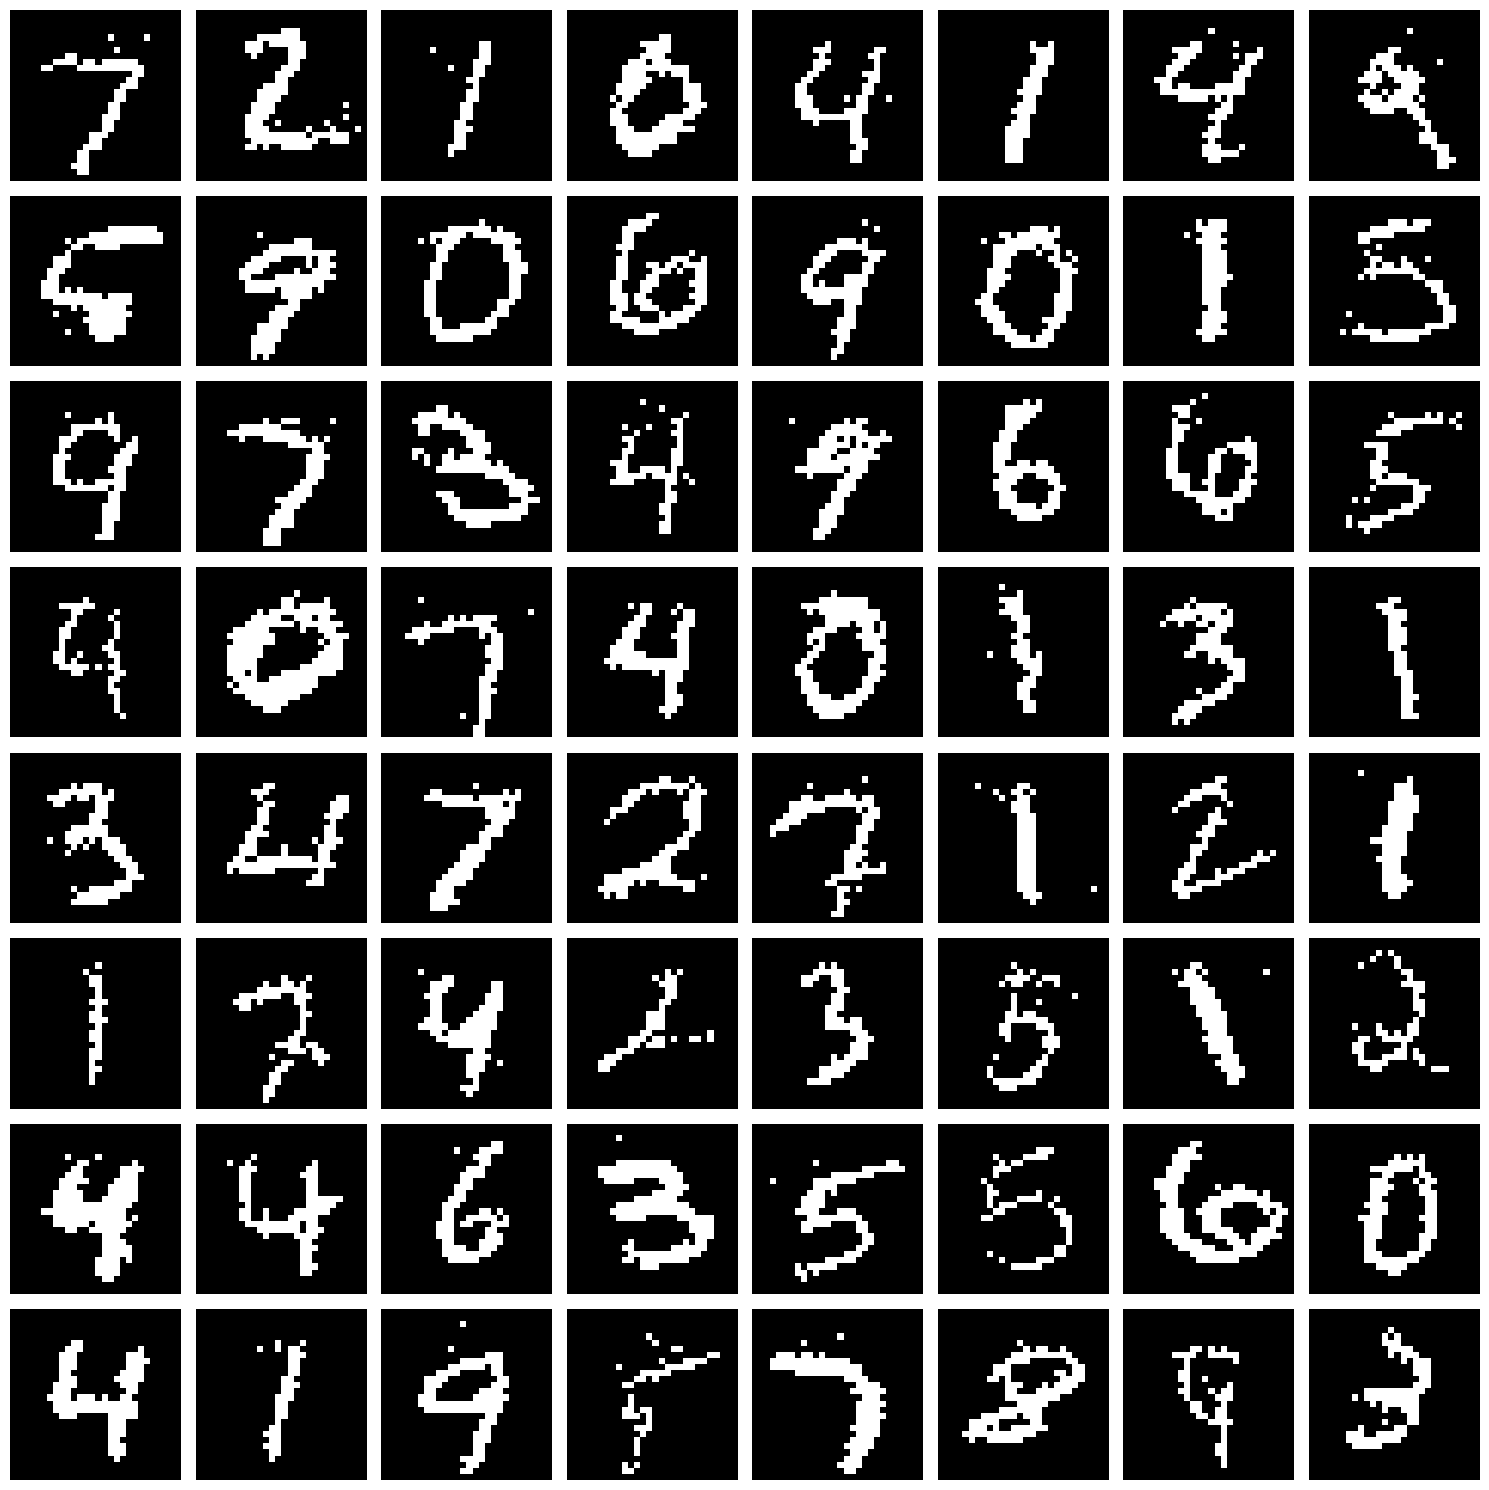

In [ ]:
H, W = 28, 28

with torch.no_grad():
  for iter, (images, labels) in enumerate(test_loader):
      images = images.to(device)
      pred = model(images)

      for i in range(H):
          for j in range(W):
              pred[:, :, i, j] = torch.bernoulli(pred[:, :, i, j], out=pred[:, :, i, j])
      break

samples = pred.detach().cpu().numpy().transpose(0, 2, 3, 1)
fig, axes = plt.subplots(8, 8, figsize=(15, 15))

for i in range(64):
    sample = samples[i]
    row, col = divmod(i, 8)
    axes[row, col].imshow(sample, cmap='gray')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

### Evaluation (Generation)

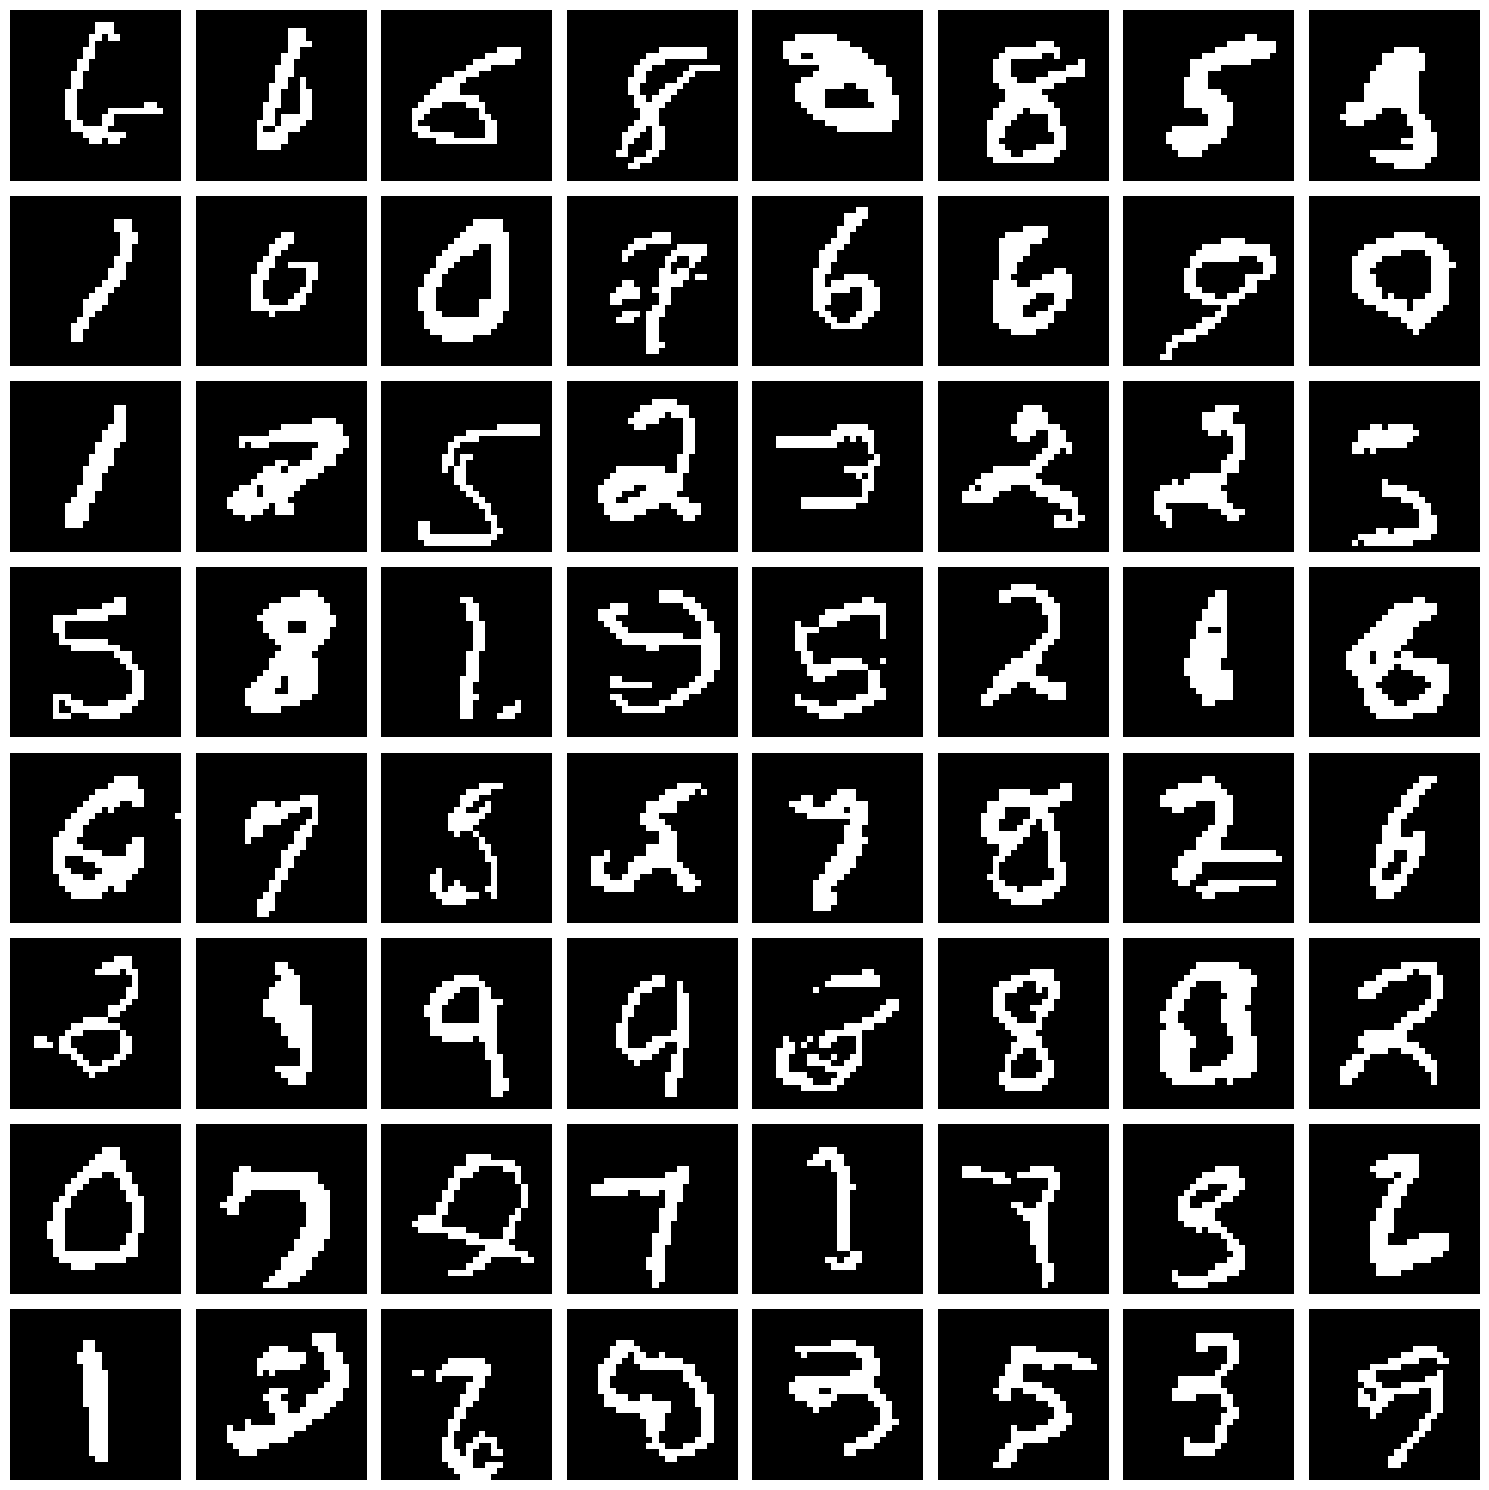

In [ ]:
samples = torch.zeros(size=(64, 1, H, W)).to(device)
with torch.no_grad():
    for i in range(H):
        for j in range(W):
            if j > 0 and i > 0:
                out = model(samples)
                samples[:, :, i, j] = torch.bernoulli(out[:, :, i, j], out=samples[:, :, i, j])

samples = samples.cpu().numpy().transpose(0, 2, 3, 1)
fig, axes = plt.subplots(8, 8, figsize=(15, 15))

for i in range(64):
    sample = samples[i]
    row, col = divmod(i, 8)
    axes[row, col].imshow(sample, cmap='gray')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

## **Conditional PixelCNN**
Conditional PixelCNNs extend the basic PixelCNN model by conditioning the generation process on additional information, such as class labels. In this part, you will implement and train a Conditional PixelCNN on the MNIST dataset, where the model is conditioned on the digit class labels.

Tasks:
- [5 pts] Extend your implementation of the `ConditionalMaskedConv2d()` function to incorporate a conditional bias based on class labels
- [5 pts] Using your `ConditionalMaskedConv2d()` function, implement the Conditional PixelCNN architecture
- [5 pts] Write your own training function. The training process is similar as in unconditional PixelCNN with some changes
- [5 pts] Train your Conditional PixelCNN on the MNIST dataset. After training, evaluate the model’s performance on the test set by generating images conditioned on specific digit classes.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda:0


In [ ]:
def train_cond(dataloader, model, optimizer, epochs, device):
    """
    Train a Conditional PixelCNN for a specified number of epochs.
    """
    model.train()
    bce = F.binary_cross_entropy
    losses_per_epoch = []

    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass (conditional)
            outputs = model(images, labels)
            loss = bce(outputs, images)  # we are modeling P(x | label)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(dataloader)
        losses_per_epoch.append(epoch_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}")

    return losses_per_epoch



### Conditional Masked Convolution
The conditional bias should be added to the output of each convolutional layer $l$ as follows:

$W_l * x + b_l + V_{ly}$

where $W_l * x + b_l$ represents the masked convolution, $V_l$ is a 2D weight matrix, and $y$ is the one-hot encoded class label. The conditional bias $V_{ly}$ should be broadcasted spatially and added to the output channel-wise.

In [ ]:
class ConditionalMaskedConv2d(nn.Conv2d):
    """
    A MaskedConv2d extended to include a label-conditioned bias term.
    """
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        mask_type='A',
        num_classes=10,
        stride=1,
        padding=0,
        dilation=1,
        groups=1,
        bias=True,
        embedding_dim=None  # if None, default to out_channels
    ):
        super().__init__(
            in_channels,
            out_channels,
            kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            groups=groups,
            bias=bias
        )
        if mask_type not in ['A', 'B']:
            raise ValueError("mask_type must be 'A' or 'B'")

        self.mask_type = mask_type

        # Construct the mask
        self.register_buffer('mask', self._make_mask())

        # Embedding for class labels --> size out_channels (or custom embedding_dim)
        if embedding_dim is None:
            embedding_dim = out_channels
        self.label_embedding = nn.Embedding(num_classes, embedding_dim)

        # If embedding_dim != out_channels, we can map embedding_dim -> out_channels
        if embedding_dim != out_channels:
            self.emb_proj = nn.Linear(embedding_dim, out_channels, bias=False)
        else:
            self.emb_proj = None

    def _make_mask(self):
        """
        Creates the mask so that each pixel only sees those that came before it.
        For mask_type='A', the center pixel is excluded.
        For mask_type='B', the center pixel is included.
        """
        mask = torch.ones_like(self.weight)  # shape [out_channels, in_channels, kH, kW]
        _, _, kH, kW = self.weight.shape

        # Identify the "center" of the kernel
        center_h = kH // 2
        center_w = kW // 2

        # Zero out everything below the current row
        mask[:, :, center_h+1:, :] = 0
        # Zero out everything to the right of the center pixel in the current row
        mask[:, :, center_h, center_w+1:] = 0

        if self.mask_type == 'A':
            # Exclude the center pixel for mask A
            mask[:, :, center_h, center_w] = 0

        return mask

    def forward(self, x, class_condition):
        """
        x: [B, in_channels, H, W]
        class_condition: [B] of integer class labels
        """
        # Normal masked convolution
        masked_weight = self.weight * self.mask
        conv_out = F.conv2d(
            x,
            masked_weight,
            self.bias,  # base bias term
            self.stride,
            self.padding,
            self.dilation,
            self.groups
        )

        # Embed the class label --> shape [B, embedding_dim]
        label_emb = self.label_embedding(class_condition)  # [B, embedding_dim]
        if self.emb_proj is not None:
            label_emb = self.emb_proj(label_emb)  # [B, out_channels]

        # Broadcast add to conv_out: conv_out is [B, out_channels, H, W]
        # So we reshape label_emb to [B, out_channels, 1, 1]
        label_emb = label_emb.unsqueeze(-1).unsqueeze(-1)
        conv_out = conv_out + label_emb

        return conv_out


### Implement Conditional PixelCNN
Using your `ConditionalMaskedConv2d()` function, implement the Conditional PixelCNN architecture. Your model should include several conditional masked convolutional layers, with the class label influencing each layer’s output through the conditional bias. The overall architecture should closely resemble the regular PixelCNN but with the additional conditioning on class labels.

In [ ]:
# -----------------------------
class ConditionalPixelCNN(nn.Module):
    """
    A minimal conditional PixelCNN for binarized MNIST.
    """
    def __init__(self, num_classes=10, in_channels=1, hidden_dim=64, kernel_size=7):
        super().__init__()

        self.conv1 = ConditionalMaskedConv2d(
            in_channels=in_channels,
            out_channels=hidden_dim,
            kernel_size=kernel_size,
            mask_type='A',
            num_classes=num_classes,
            padding=kernel_size//2
        )
        self.conv2 = ConditionalMaskedConv2d(
            in_channels=hidden_dim,
            out_channels=hidden_dim,
            kernel_size=kernel_size,
            mask_type='B',
            num_classes=num_classes,
            padding=kernel_size//2
        )
        self.conv3 = ConditionalMaskedConv2d(
            in_channels=hidden_dim,
            out_channels=hidden_dim,
            kernel_size=kernel_size,
            mask_type='B',
            num_classes=num_classes,
            padding=kernel_size//2
        )
        self.conv_out = ConditionalMaskedConv2d(
            in_channels=hidden_dim,
            out_channels=1,
            kernel_size=1,
            mask_type='B',
            num_classes=num_classes,
            padding=0
        )

    def forward(self, x, labels):
        """
        x: [B, 1, H, W]
        labels: [B] of integer class labels
        """
        x = F.relu(self.conv1(x, labels))
        x = F.relu(self.conv2(x, labels))
        x = F.relu(self.conv3(x, labels))
        x = self.conv_out(x, labels)

        # Convert logits to probabilities
        x = torch.sigmoid(x)
        return x


### Training

In [ ]:
epochs = 100
n_classes = 10
model = ConditionalPixelCNN(n_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

log = train_cond(train_loader, model, optimizer, epochs, device)



Epoch [1/100], Loss: 0.1453
Epoch [2/100], Loss: 0.0927
Epoch [3/100], Loss: 0.0883
Epoch [4/100], Loss: 0.0863
Epoch [5/100], Loss: 0.0848
Epoch [6/100], Loss: 0.0836
Epoch [7/100], Loss: 0.0828
Epoch [8/100], Loss: 0.0822
Epoch [9/100], Loss: 0.0815
Epoch [10/100], Loss: 0.0811
Epoch [11/100], Loss: 0.0806
Epoch [12/100], Loss: 0.0803
Epoch [13/100], Loss: 0.0799
Epoch [14/100], Loss: 0.0796
Epoch [15/100], Loss: 0.0794
Epoch [16/100], Loss: 0.0791
Epoch [17/100], Loss: 0.0789
Epoch [18/100], Loss: 0.0786
Epoch [19/100], Loss: 0.0785
Epoch [20/100], Loss: 0.0783
Epoch [21/100], Loss: 0.0782
Epoch [22/100], Loss: 0.0780
Epoch [23/100], Loss: 0.0779
Epoch [24/100], Loss: 0.0777
Epoch [25/100], Loss: 0.0776
Epoch [26/100], Loss: 0.0775
Epoch [27/100], Loss: 0.0774
Epoch [28/100], Loss: 0.0772
Epoch [29/100], Loss: 0.0772
Epoch [30/100], Loss: 0.0771
Epoch [31/100], Loss: 0.0770
Epoch [32/100], Loss: 0.0769
Epoch [33/100], Loss: 0.0768
Epoch [34/100], Loss: 0.0767
Epoch [35/100], Loss: 0

### Evaluation (Reconstruction)

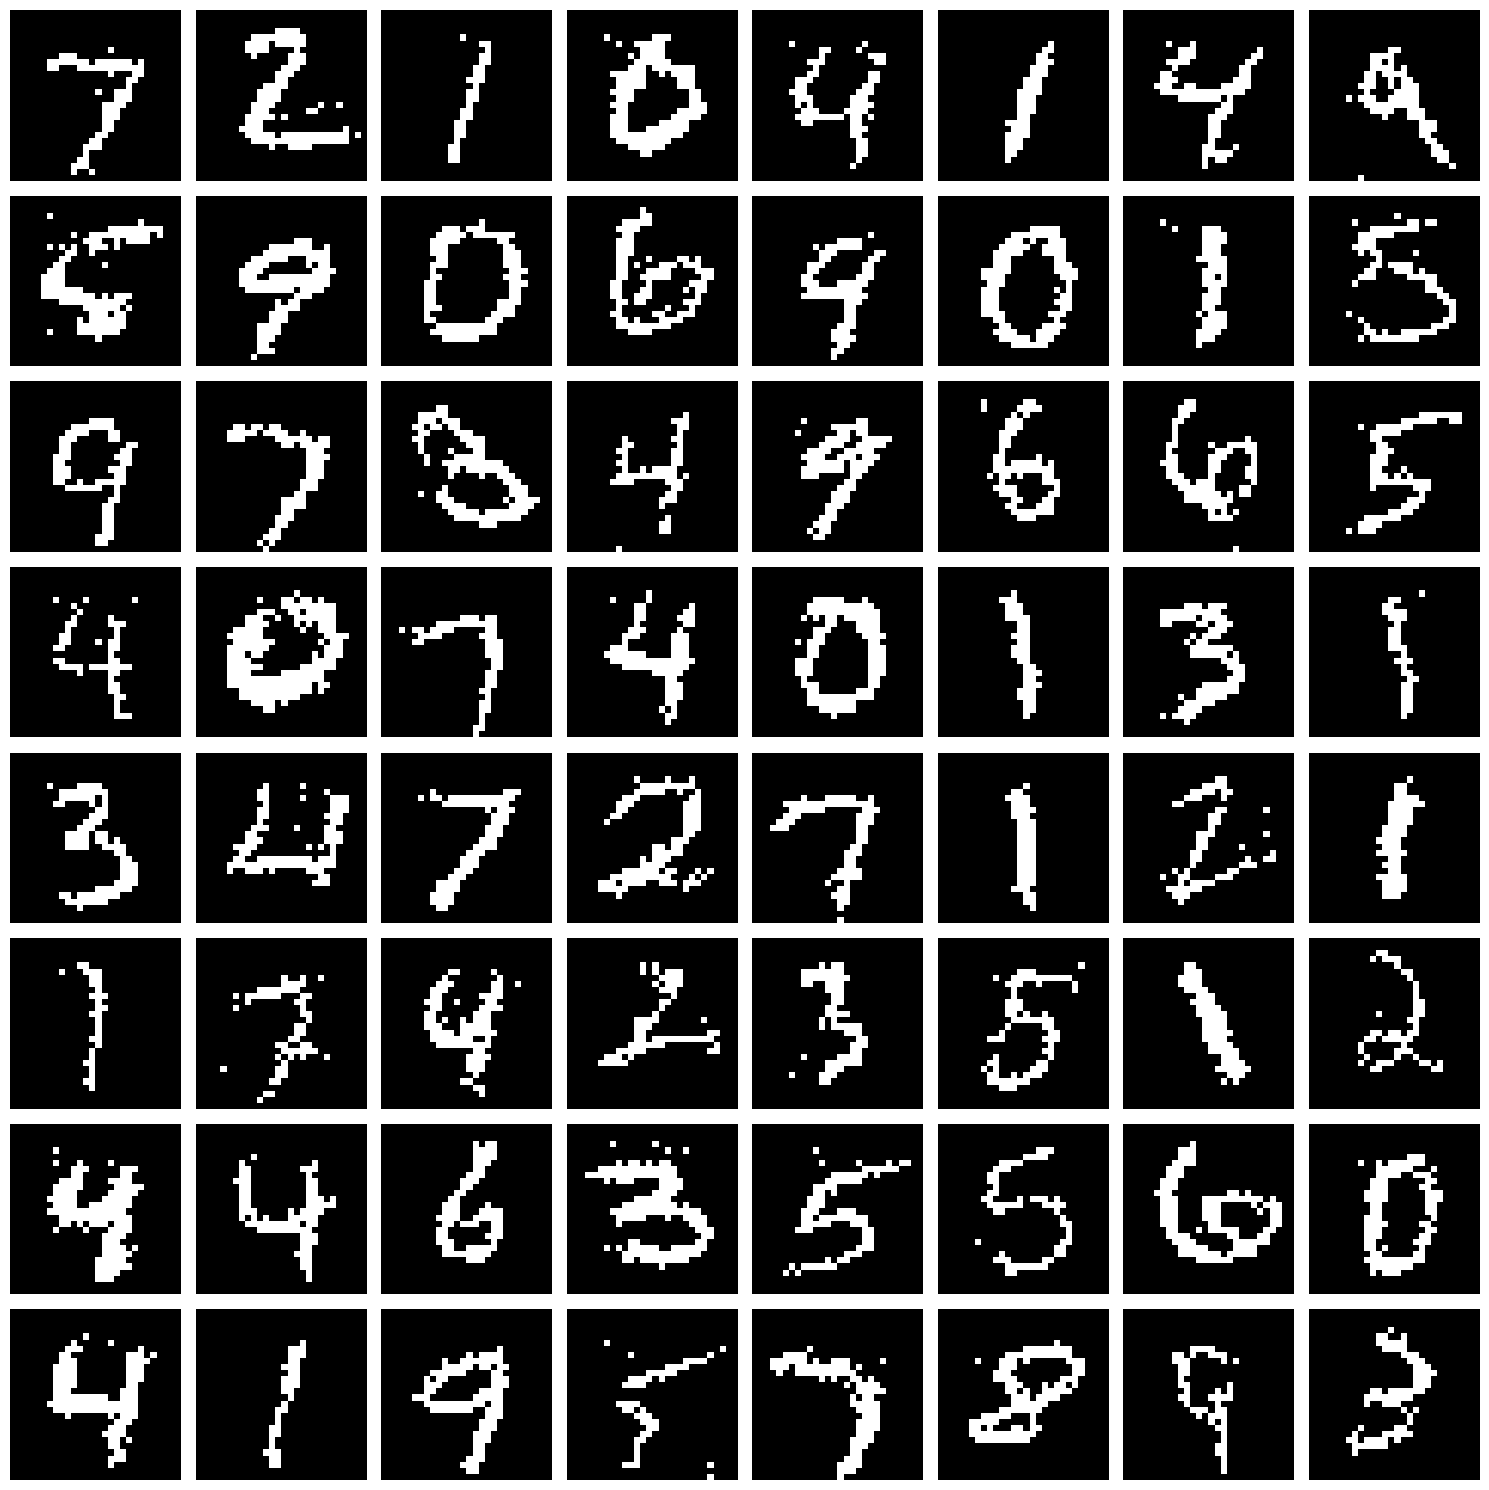

In [ ]:
model.eval()

H, W = 28, 28
n_classes = 10

with torch.no_grad():
    # -- (1) Grab one batch from test_loader --
    # We'll just loop once and break:
    for images, labels in test_loader:
        # Move the batch to the proper device
        images = images.to(device)
        labels = labels.to(device)  # integer labels

        # -- (2) Forward pass -> get probability maps for each pixel
        pred_probs = model(images, labels)  # shape [B, 1, H, W]

        # -- (3) Sample from Bernoulli distribution pixel by pixel
        samples_bernoulli = torch.zeros_like(pred_probs)
        for i in range(H):
            for j in range(W):
                samples_bernoulli[:, :, i, j] = torch.bernoulli(pred_probs[:, :, i, j])

        # We only wanted one batch, so break
        break

# -- (4) Convert to numpy and plot the first 64 images --
samples_np = samples_bernoulli.detach().cpu().numpy().transpose(0, 2, 3, 1)

fig, axes = plt.subplots(8, 8, figsize=(15, 15))
for i in range(64):
    sample = samples_np[i]
    row, col = divmod(i, 8)
    axes[row, col].imshow(sample.squeeze(), cmap='gray')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

### Evaluation (Generation)

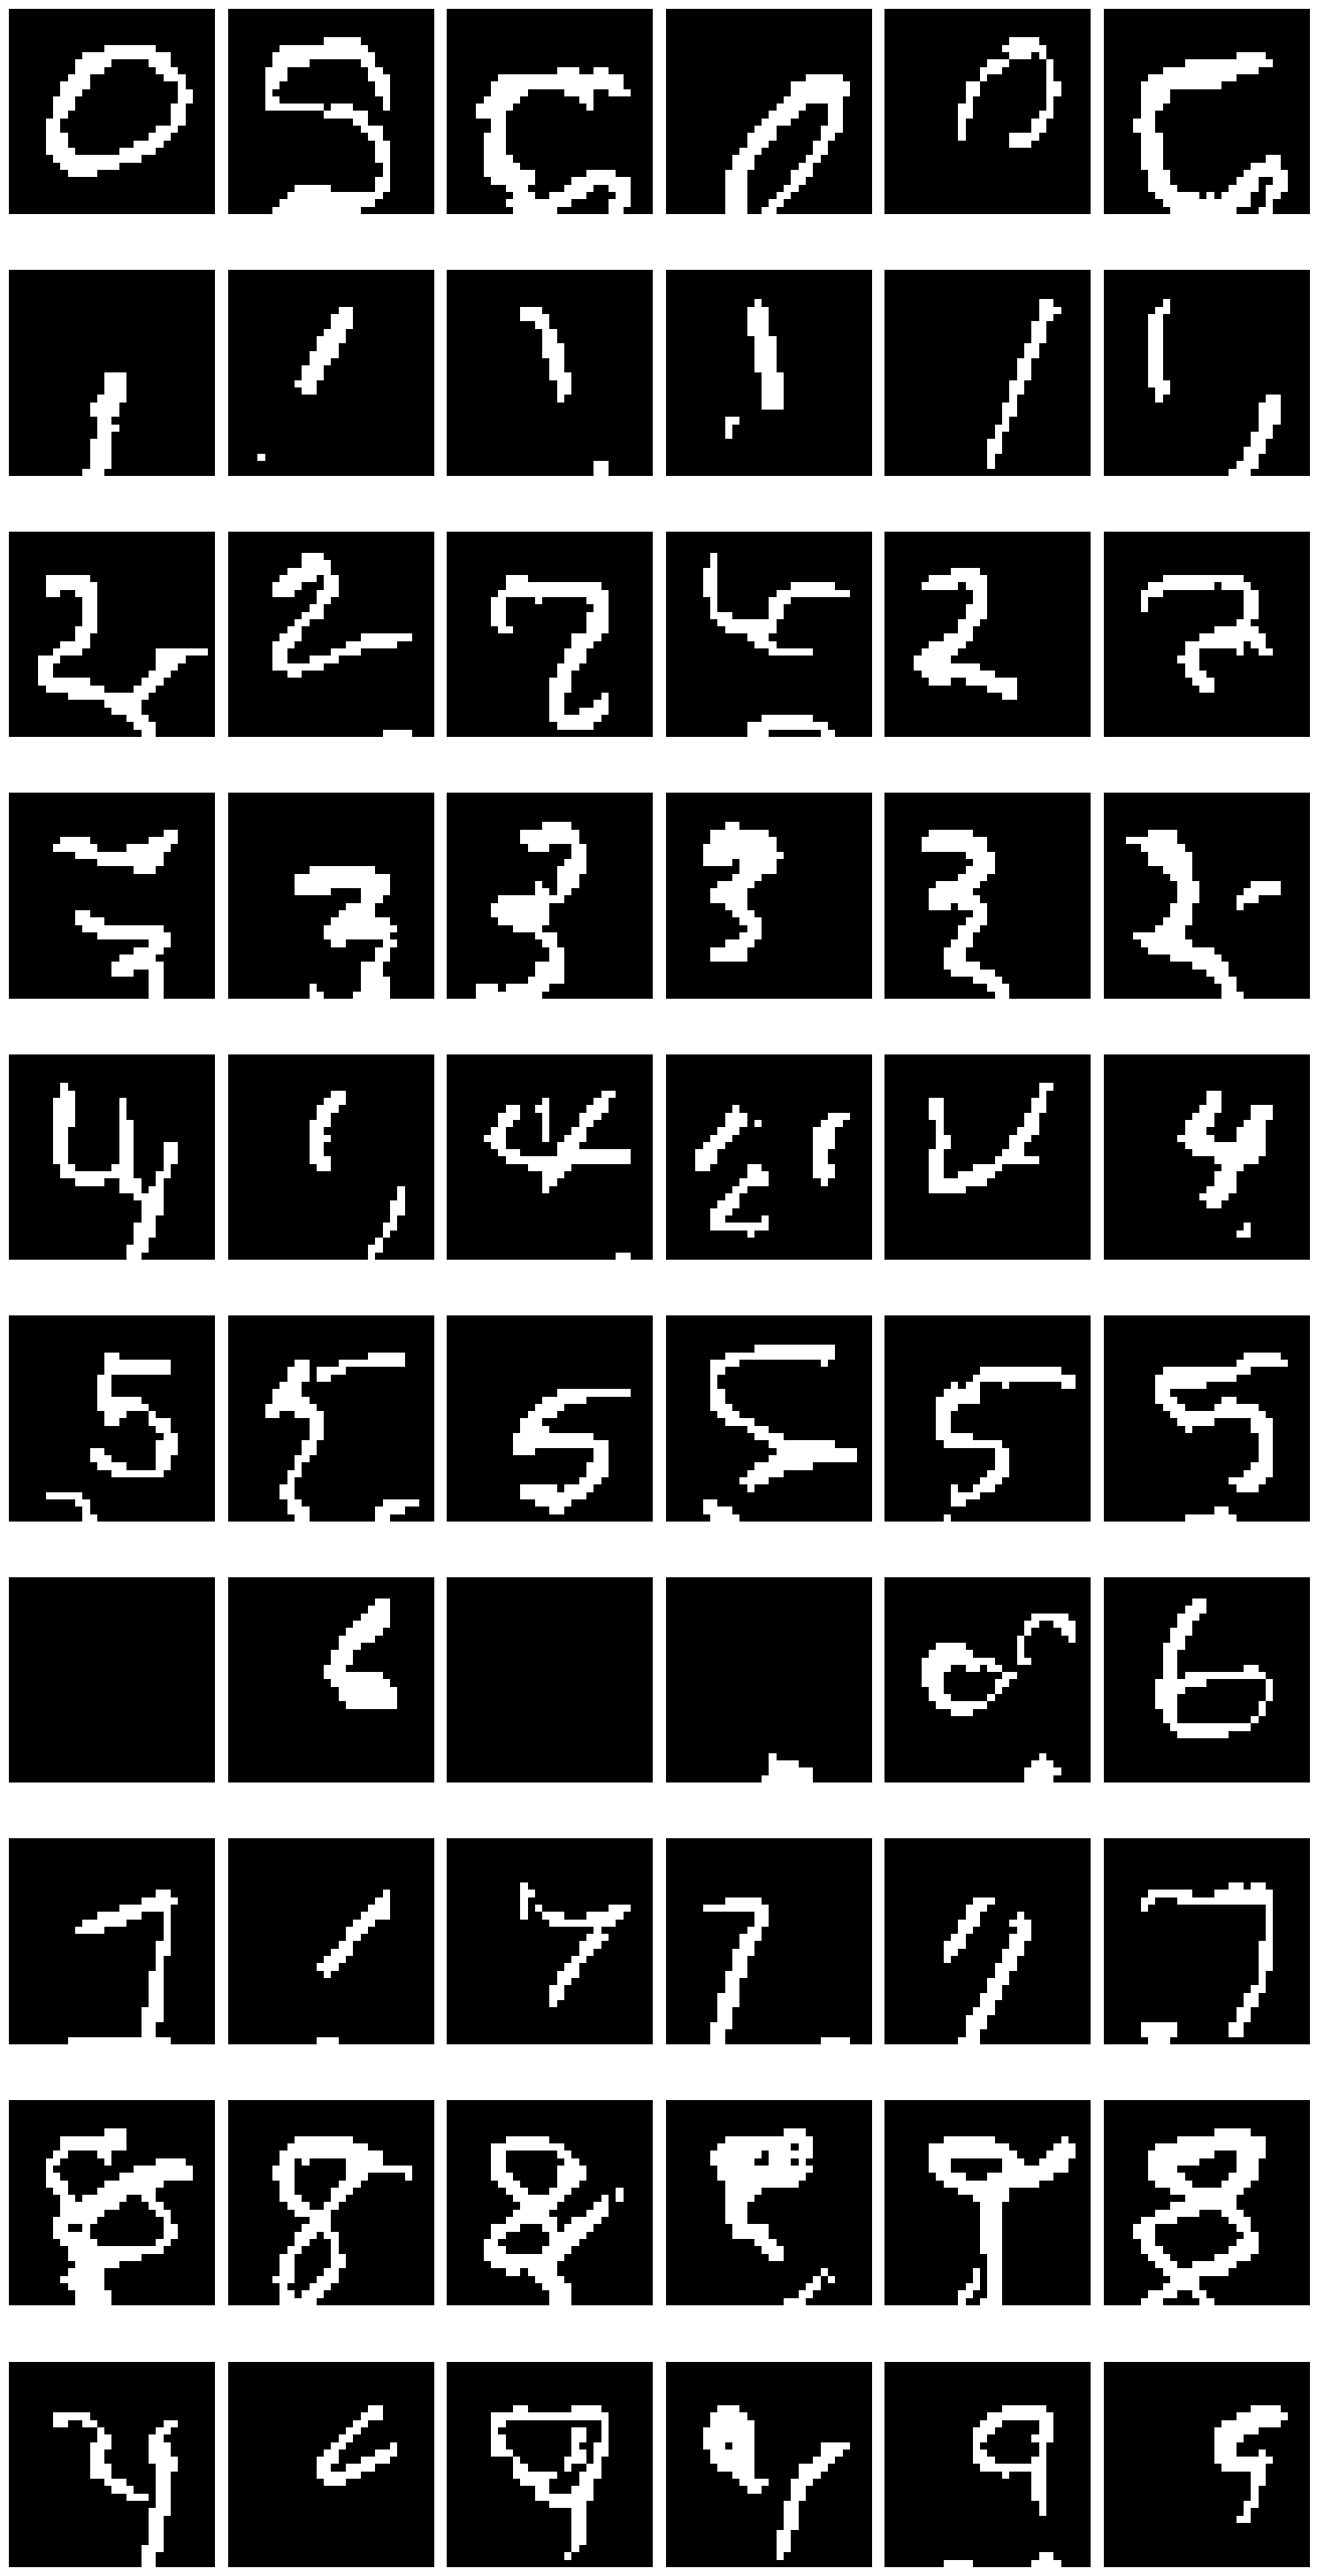

In [ ]:
# 1) Prepare the sampling tensor of zeros
samples = torch.zeros(size=(60, 1, H, W), device=device)

# 2) Create a sorted array of repeated classes:
#    We'll have classes [0..9] repeated 6 times -> total 60
sample_classes_array = np.sort(np.array([np.arange(n_classes)] * 6).flatten())  # shape = (60,)

# 3) Convert to LONG tensor so it matches nn.Embedding input expectations
sample_classes_idx = torch.tensor(sample_classes_array, dtype=torch.long, device=device)

# 4) Autoregressive sampling
model.eval()
with torch.no_grad():
    for i in range(H):
        for j in range(W):
            # Forward pass:  shape [60, 1, H, W]
            out = model(samples, sample_classes_idx)
            # Sample from the Bernoulli distribution for pixel (i, j)
            samples[:, :, i, j] = torch.bernoulli(out[:, :, i, j])

# 5) Convert to numpy and plot results in a 10 x 6 grid
samples_np = samples.cpu().numpy().transpose(0, 2, 3, 1)

fig, axes = plt.subplots(10, 6, figsize=(15, 30))
for i in range(60):
    row, col = divmod(i, 6)
    axes[row, col].imshow(samples_np[i].squeeze(), cmap='gray')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()